In [1]:
import os
import cv2
import json
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil

In [3]:
from tensorflow.keras import utils

import tensorflow as tf

# Path ke dataset

data_dir = "/content/drive/MyDrive/TUBES6/Dental OPG XRAY Dataset/Dental OPG (Classification)"



# Load training data

train_data = utils.image_dataset_from_directory(

    data_dir,

    labels="inferred",

    label_mode="int",

    validation_split=0.1,

    subset="training",

    shuffle=True,

    color_mode="rgb",

    image_size=(299, 299),

    batch_size=16,

    seed=40,

)



# Load validation data

data_valid = utils.image_dataset_from_directory(

    data_dir,

    labels="inferred",

    label_mode="int",

    validation_split=0.1,

    subset="validation",

    shuffle=True,

    color_mode="rgb",

    image_size=(299, 299),

    batch_size=16,

    seed=40,

)



# Verifikasi dataset

class_names = train_data.class_names

print("Classes:", class_names)



# Menampilkan beberapa batch data

for images, labels in train_data.take(1):

    print("Shape of image batch:", images.shape)

    print("Shape of label batch:", labels.shape)

Found 229 files belonging to 3 classes.
Using 207 files for training.
Found 229 files belonging to 3 classes.
Using 22 files for validation.
Classes: ['BDC-BDR', 'Caries', 'Healthy Teeth']
Shape of image batch: (16, 299, 299, 3)
Shape of label batch: (16,)


In [4]:
# Normalisasi data

def normalize(image, label):

  return image/255.0, label

train_data = train_data.map(normalize)

data_valid= data_valid.map(normalize)

In [5]:
for img, label in train_data.take(1):

  print(type(img),type(label))

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


In [6]:
train_x=[]

train_y=[]

for image,label in train_data:

   train_x.append(image)

   train_y.append(label)

train_x = tf.concat(train_x, axis=0)

train_y = tf.concat(train_y, axis=0)

In [7]:
val_x=[]

val_y=[]

for image,label in train_data:

   val_x.append(image)

   val_y.append(label)

val_x = tf.concat(val_x, axis=0)

val_y = tf.concat(val_y, axis=0)

In [8]:
#one hot encode

num_classes = 3

train_y = tf.keras.utils.to_categorical(train_y, num_classes=num_classes)

val_y = tf.keras.utils.to_categorical(val_y, num_classes=num_classes)

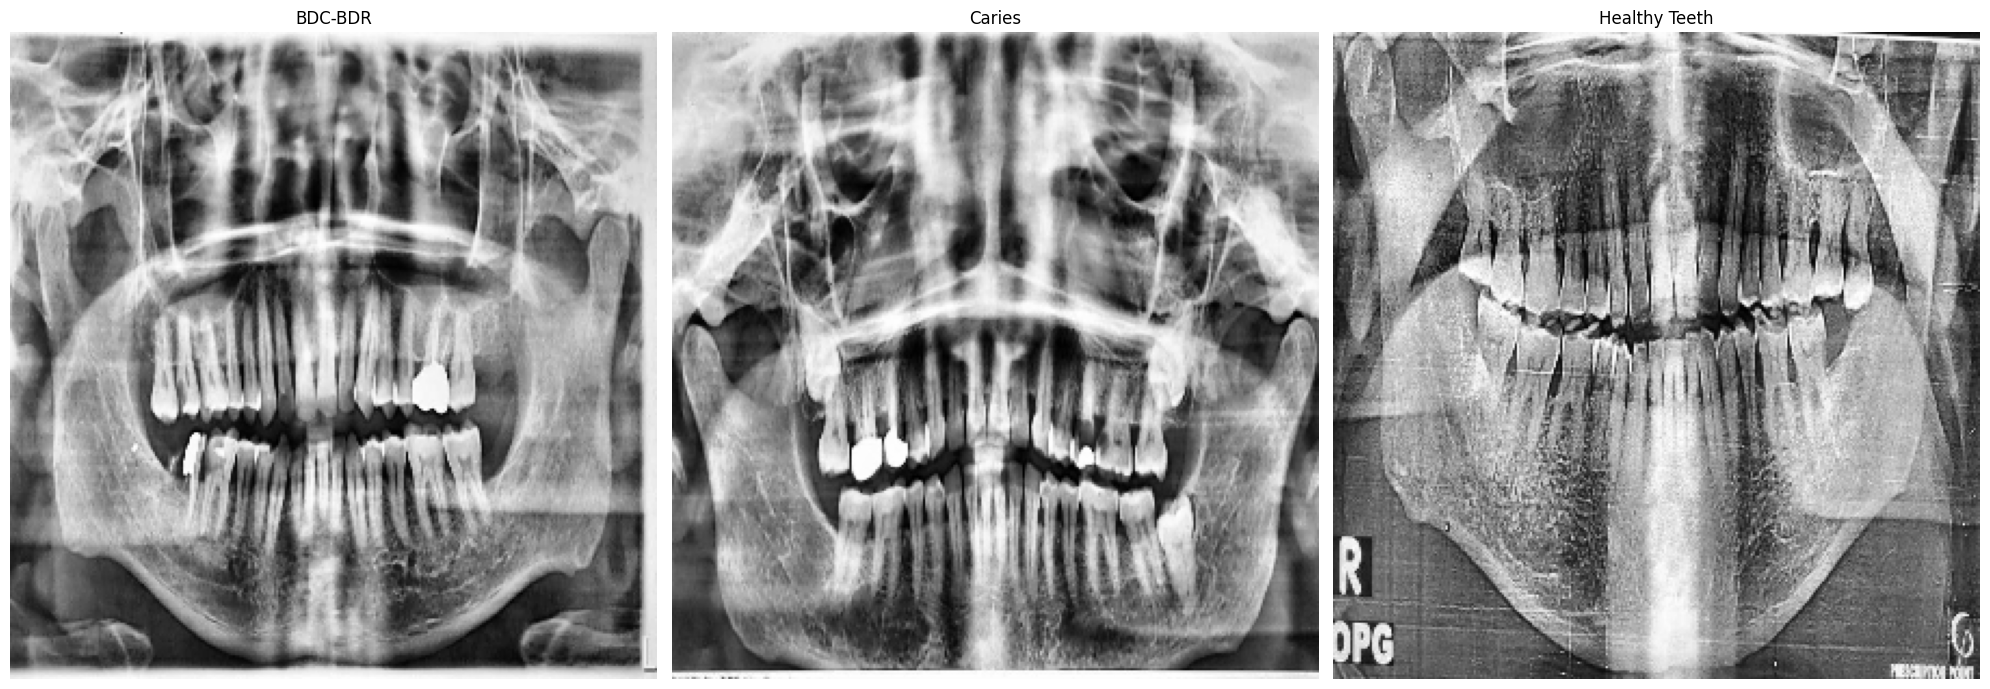

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels
class_labels = [
    'BDC-BDR', 'Caries', 'Healthy Teeth'
]

# Create the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Loop untuk setiap kelas
for idx, (ax, kelas) in enumerate(zip(axes.flat, range(len(class_labels)))):
    # Pilih gambar dari kelas yang dipilih
    gambar_kelas = train_x[train_y[:, kelas] == 1]

    # Plotkan gambar pertama dari kelas yang dipilih
    ax.imshow(gambar_kelas[0], cmap='gray')
    ax.set_title(class_labels[kelas])
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [10]:
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras import layers, models

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Input



# Define the input shape

input_shape = (299, 299, 3)



# Build the InceptionV3 model with data augmentation and learning rate scheduling

def build_inceptionv3(input_shape=(299, 299, 3), num_classes=3):

    # Define the input layer

    inputs = Input(shape=input_shape)



    # Load InceptionV3 model with pre-trained weights from ImageNet

    base_model = InceptionV3(input_shape=input_shape,

                             include_top=False,  # Exclude the top (fully connected) layers

                             weights='imagenet')(inputs)



    # Freeze the layers of the pre-trained model

    base_model.trainable = False



    # Create the custom model on top of the pre-trained base model

    x = layers.GlobalAveragePooling2D()(base_model)  # Global average pooling layer

    x = layers.Dense(1024, activation='relu')(x)  # Fully connected layer

    x = layers.Dropout(0.5)(x)  # Dropout for regularization

    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation



    # Create the final model

    model = models.Model(inputs, outputs)



    # Compile the model with reduced learning rate

    optimizer = Adam(learning_rate=0.0001)

    model.compile(optimizer=optimizer,

                  loss='categorical_crossentropy',

                  metrics=['accuracy'])

    return model



# Add data augmentation and learning rate scheduler

datagen = ImageDataGenerator(

    rotation_range=30,

    width_shift_range=0.2,

    height_shift_range=0.2,

    shear_range=0.2,

    zoom_range=0.2,

    horizontal_flip=True,

    fill_mode='nearest'

)



# Learning rate scheduler function

def scheduler(epoch, lr):

    if epoch > 15:

        return lr * 0.1  # Reduce learning rate by a factor of 10 after 10 epochs

    return lr



lr_scheduler = LearningRateScheduler(scheduler)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



# Build the model

model = build_inceptionv3(input_shape=input_shape, num_classes=3)



# Fit the model with data augmentation and callbacks, set epochs to 15

history = model.fit(datagen.flow(train_x, train_y, batch_size=16),

                    epochs=40,

                    validation_data=(val_x, val_y),

                    callbacks=[early_stopping, lr_scheduler])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 175s 7s/step - accuracy: 0.2990 - loss: 1.2031 - val_accuracy: 0.4058 - val_loss: 1.1397 - learning_rate: 1.0000e-04
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 321ms/step - accuracy: 0.4579 - loss: 1.0310 - val_accuracy: 0.4010 - val_loss: 1.3047 - learning_rate: 1.0000e-04
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 420ms/step - accuracy: 0.5415 - loss: 0.9637 - val_accuracy: 0.5072 - val_loss: 1.0453 - learning_rate: 1.0000e-04
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step - accuracy: 0.6440 - loss: 0.8125 - val_accuracy: 0.5604 - val_loss: 0.9961 - learning_rate: 1.0000e-04
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - accuracy: 0.5396 - loss: 0.9325 - val_accuracy: 0.5507 - val_loss: 0.9543 - learning_rate: 1.0000e-04
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - accuracy: 0.6739 - loss: 0.7642 - val_accuracy: 0.5121 - val_loss: 1.1220 - learning_rate: 1.0000e-04
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 428ms/step - accuracy: 0.6725 - lo

In [11]:
jumlah_variasi = len(datagen.flow(train_x, train_y, batch_size=16))
print(jumlah_variasi)

13


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9284 - loss: 0.1812
Validation Loss: 0.14840435981750488, Validation Accuracy: 0.9420289993286133


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,643,243 (273.30 MB)

 Trainable params: 23,869,603 (91.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 47,739,208 (182.11 MB)

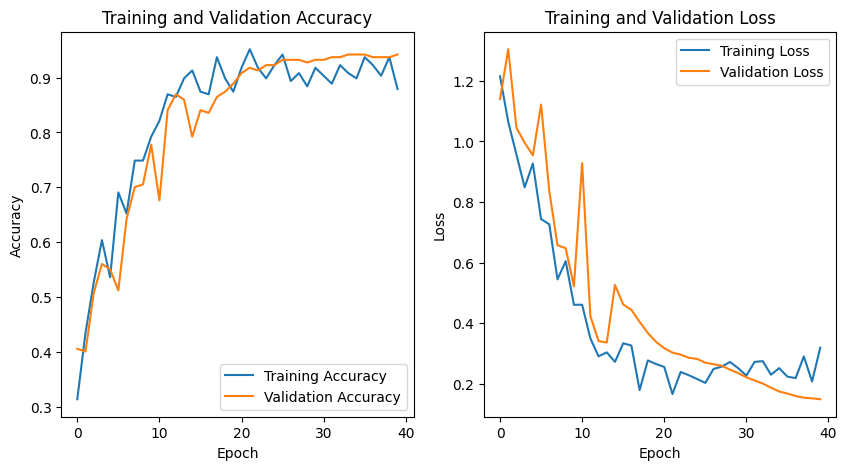

In [12]:
# Evaluasi model

loss, accuracy = model.evaluate(val_x, val_y)

print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')



model.summary()





# Plot the accuracy and validation loss

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')

plt.ylabel('Accuracy')

plt.legend()

plt.title('Training and Validation Accuracy')



plt.subplot(1, 2, 2)

plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()

plt.title('Training and Validation Loss')



plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
Classification Report:
               precision    recall  f1-score   support

      BDC-BDR       1.00      0.83      0.90        46
       Caries       0.94      0.98      0.96        81
Healthy Teeth       0.92      0.97      0.95        80

     accuracy                           0.94       207
    macro avg       0.95      0.93      0.94       207
 weighted avg       0.94      0.94      0.94       207



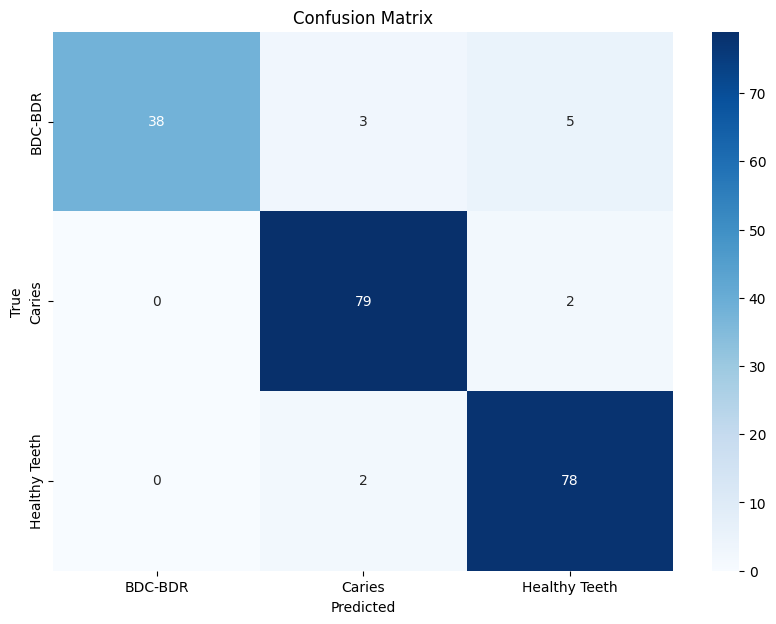

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np





# Example class names (replace with your actual class names)

class_names = ['BDC-BDR', 'Caries', 'Healthy Teeth']



# Predict on the validation set

y_pred = model.predict(val_x)

y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices



# Convert true labels to class indices

y_true = np.argmax(val_y, axis=1)



# Print the classification report

print("Classification Report:")

print(classification_report(y_true, y_pred_classes, target_names=class_names))



# Confusion Matrix

conf_matrix = confusion_matrix(y_true, y_pred_classes)



# Plot the confusion matrix

plt.figure(figsize=(10, 7))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')

plt.ylabel('True')

plt.title('Confusion Matrix')

plt.show()